# Nested cross validation

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, accuracy_score

from matplotlib.ticker import FormatStrFormatter



In [9]:
#| label: importdata
# Import data
df = pd.read_csv("./data/UV_pilot.csv")


In [10]:
#| label: splitdata
# Split features and target
X = df.loc[:,"4000":"403"]
y = df.loc[:,"Exposed"]

In [13]:
#| label: parameters_nested

scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)
splits_outer = 3
splits_inner = 3

pipe = Pipeline(steps=[("scaler", scaler), ("model", model)])

# configure nested cross-validation layers
cv_outer = KFold(n_splits=splits_outer, shuffle=True, random_state=123)
cv_inner = KFold(n_splits=splits_inner, shuffle=True, random_state=123)

In [46]:
#|label: nested_loop
# create confusion matrix list to save each of external cv layer
cm_nested = []

# enumerate splits and create AUC plot
yhat_nested = []
y_test_nested = []
X_test_nested = []
best_estimators = []
mean_fpr = np.linspace(0, 1, 100)
outer_results = list()


for train_ix, test_ix in cv_outer.split(X):
# split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    # define search space
    param_grid = {'model__penalty': ['l1', 'l2'],
                  'model__C': [0.01, 0.1, 1, 10],
                  'model__solver': ['liblinear', 'saga']
                  }
    # define search

    search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_

    # create pipeline with the best model
    best_pipe = Pipeline(steps=[("scaler", scaler), ("best_model", best_model)])
    best_pipe.fit(X_train, y_train)
    # evaluate model on the hold out dataset

    yhat = best_pipe.predict(X_test)

    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    cm = confusion_matrix(y_test, yhat)
    yhat_nested.append(yhat)

    y_test_nested.append(y_test)
    X_test_nested.append(X_test)
    
     # store the result
    outer_results.append(acc)
    cm_nested.append(cm)
    best_estimators.append(best_pipe)
    
    print(f'Accuracy = {result.best_score_:.2f}, Parameters={result.best_params_}')
    
# summarize the estimated performance of the model
print(f'Final accuracy = {np.mean(outer_results):.2f} ±  {np.std(outer_results):.2f}')


Accuracy = 0.92, Parameters={'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Accuracy = 0.87, Parameters={'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Accuracy = 0.85, Parameters={'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Final accuracy = 0.88 ±  0.05


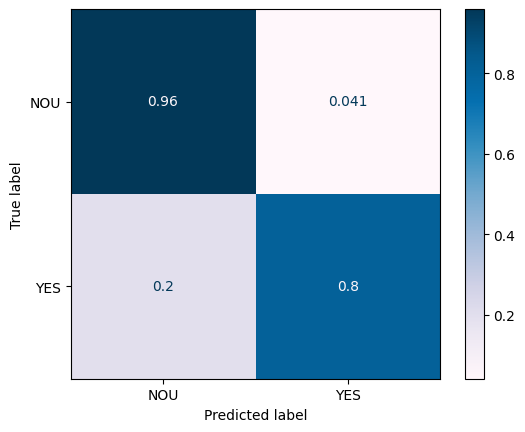

In [40]:
#|label: nested_cm

# sum all the confusion matrices
cm_sum = np.sum(cm_nested,axis=0)

# we normalised the confusion matrix
cm_sum_normalized = cm_sum.astype('float')/cm_sum.sum(axis=1)[:, np.newaxis]
                                                              
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum_normalized, display_labels=best_model.classes_)
disp.plot(cmap = "PuBu")

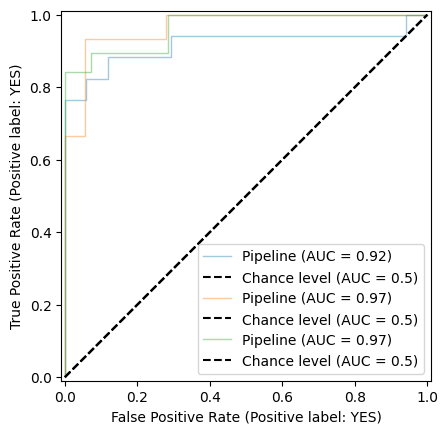

In [56]:
#|label: auc_roc

# AUC-ROC curve

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []


fig, ax = plt.subplots()
for a, b, c in zip(X_test_nested,y_test_nested, best_estimators):
        viz = RocCurveDisplay.from_estimator(
        c,
        a,
        b,
        alpha=0.4,
        lw=1,
        plot_chance_level = True,
        ax=ax)

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

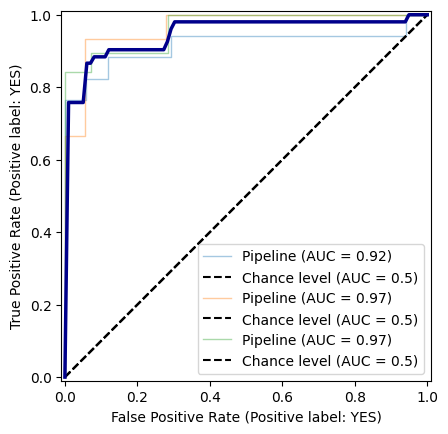

In [57]:
#|label: auc_roc_final

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

fig, ax = plt.subplots()
for a, b, c in zip(X_test_nested,y_test_nested, best_estimators):
        viz = RocCurveDisplay.from_estimator(
        c,
        a,
        b,
        alpha=0.4,
        lw=1,
        plot_chance_level = True,
        ax=ax)

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

ax.plot(
        mean_fpr,
        mean_tpr,
        color="darkblue",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2.5,
        alpha=1)



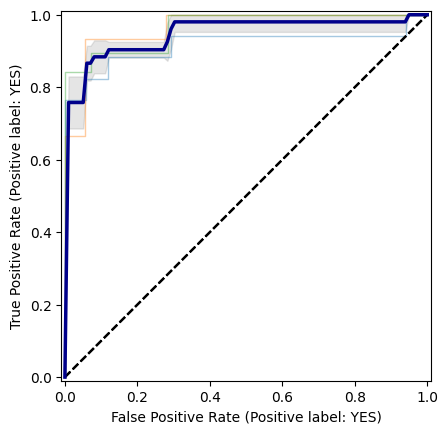

In [59]:
# | label: final_roc
fig, ax = plt.subplots()
for a, b, c in zip(X_test_nested,y_test_nested, best_estimators):
        viz = RocCurveDisplay.from_estimator(
        c,
        a,
        b,
        alpha=0.4,
        lw=1,
        plot_chance_level = True,
        ax=ax)

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

ax.plot(
        mean_fpr,
        mean_tpr,
        color="darkblue",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2.5,
        alpha=1)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2)

ax.get_legend().remove()